In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import (TransformerMixin, BaseEstimator)
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import (PCA, TruncatedSVD)
from sklearn.metrics import (mean_absolute_error, mean_squared_error)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor)
from sklearn.linear_model import (LinearRegression, SGDRegressor, LassoCV, RidgeCV)
from sklearn.svm import (SVR, LinearSVR)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import pickle

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# variable utilisées
category = ["op_unique_carrier", "dest", "arr_day_of_year"]
time_var = ["arr_hour"]
holidays = ["holidays"]
targets_label = ["arr_delay"]

In [3]:
df = pd.read_csv("../data/data_clean.csv", usecols=category+targets_label+holidays+time_var)

In [4]:
df["cos_hr"] = np.cos(df.arr_hour*(2*np.pi/24))
df["sin_hr"] = np.sin(df.arr_hour*(2*np.pi/24))
cycle_var = ["cos_hr", "sin_hr"]
df = df.drop(time_var, axis=1)

# Pre-treatment

In [5]:
def supp_outliers(df, col):

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    inf  = q1 - 1.5 * iqr
    sup = q3 + 1.5 * iqr
    df_out = df.loc[(df[col] > inf) & (df[col] < sup)]
    
    obs_supp = df.shape[0] - df_out.shape[0]
    ratio = (obs_supp/df.shape[0])*100
    
    
    print("Lower terminals : [{0:.0f}]".format(inf))
    print("Upper terminals : [{0:.0f}]".format(sup))
    print("Number of outliers removed : {0} ({1:.0f}% data)".format(obs_supp, ratio))
    
    return df_out

In [6]:
df = supp_outliers(df, "arr_delay")

Lower terminals : [-44]
Upper terminals : [36]
Number of outliers removed : 526545 (10% data)


In [7]:
df[category + holidays] = df[category + holidays].astype("category")

In [8]:
data = df.loc[:, category + holidays + cycle_var]
targets = df.loc[:, targets_label]

## Encoding variables

In [9]:
class DummyEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, n_values='auto'):
        self.n_values = n_values

    def transform(self, X):
        ohe = OneHotEncoder(sparse=True, n_values=self.n_values)
        return ohe.fit_transform(X)[:,:-1]

    def fit(self, X, y=None, **fit_params):
        return self

In [10]:
cat_transformers = make_pipeline(DummyEncoder())

preprocess = ColumnTransformer([('cat', cat_transformers, category+holidays)], remainder="passthrough")

In [11]:
data_t = preprocess.fit_transform(data)

# Modelization

## Split the data

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(data_t, targets)

## Baseline

In [13]:
lr_dummy = DummyRegressor(strategy="mean")
lr_dummy.fit(X_train, Y_train)
pred_dummy = lr_dummy.predict(X_test)
mean_absolute_error(Y_test, pred_dummy)

10.68649828809022

## Regression by SGD without regularization

In [14]:
sgd = SGDRegressor(alpha=0)
sgd.fit(X_train, Y_train)

SGDRegressor(alpha=0, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [15]:
pred = sgd.predict(X_test)
mean_absolute_error(Y_test, pred)

10.327824672184809

## Lasso Regression

In [16]:
param_grid = {"alpha": np.linspace(1e-8, 0.1, 20)}

sgd_lasso = SGDRegressor(penalty="l1", l1_ratio=1)

lasso = GridSearchCV(sgd_lasso, param_grid, cv=5, iid=False, scoring="neg_mean_absolute_error")
lasso.fit(X_train, Y_train);

In [17]:
print(lasso.best_params_)

{'alpha': 1e-08}


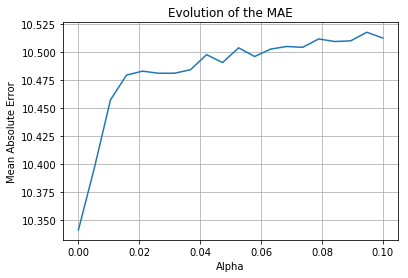

In [18]:
df_result = pd.DataFrame(lasso.cv_results_)
plt.plot(df_result.param_alpha, np.abs(df_result.mean_test_score))
plt.title("Evolution of the MAE")
plt.xlabel("Alpha")
plt.ylabel("Mean Absolute Error")
plt.grid()

In [19]:
pred = lasso.predict(X_test)
mean_absolute_error(Y_test, pred)

10.348493631837659

## Regression ridge

In [20]:
param_grid = {"alpha": np.linspace(1e-8, 0.1, 10)}

sgd_ridge = SGDRegressor(penalty="l2", l1_ratio=0)

ridge = GridSearchCV(sgd_ridge, param_grid, cv=5, iid=False, scoring="neg_mean_absolute_error")
ridge.fit(X_train, Y_train);

In [21]:
print(ridge.best_params_)

{'alpha': 1e-08}


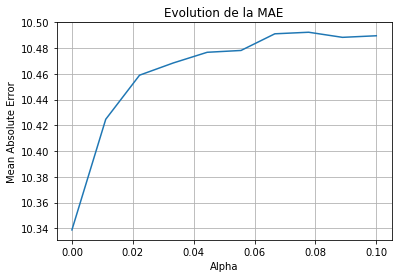

In [22]:
df_result = pd.DataFrame(ridge.cv_results_)
plt.plot(df_result.param_alpha, np.abs(df_result.mean_test_score))
plt.title("Evolution de la MAE")
plt.xlabel("Alpha")
plt.ylabel("Mean Absolute Error")
plt.grid()

In [23]:
pred = ridge.predict(X_test)
mean_absolute_error(Y_test, pred)

10.326216724216298

## Regression by SGD (Huber)

In [24]:
param_grid = {"epsilon": np.linspace(1, 10, 10)}

sgd_huber= SGDRegressor(loss="huber", alpha=0)

huber = GridSearchCV(sgd_huber, param_grid, cv=5, iid=False, scoring="neg_mean_absolute_error")
huber.fit(X_train, Y_train);

In [25]:
print(huber.best_params_)

{'epsilon': 6.0}


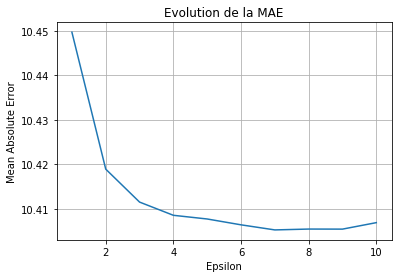

In [27]:
df_result = pd.DataFrame(huber.cv_results_)
plt.plot(df_result.param_epsilon, np.abs(df_result.mean_test_score))
plt.title("Evolution de la MAE")
plt.xlabel("Epsilon")
plt.ylabel("Mean Absolute Error")
plt.grid()

In [28]:
pred = huber.predict(X_test)
mean_absolute_error(Y_test, pred)

10.424883020527078

# Modèle utiliser par l'api (Regression Huber)

In [29]:
from sklearn.externals import joblib
joblib.dump(preprocess, "models/preprocess.joblib")
joblib.dump(huber, "models/huber.joblib")

FileNotFoundError: [Errno 2] No such file or directory: 'models/preprocess.joblib'